In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import os
import time
import warnings
import os
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew
from sklearn.preprocessing import StandardScaler

In [2]:
#Add All the Models Libraries

# Scalers
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# Models

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error

from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix
from scipy.stats import reciprocal, uniform

from sklearn.model_selection import StratifiedKFold

# Cross-validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.model_selection import cross_validate

# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Common data processors
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from scipy import sparse

In [3]:
# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [4]:
train = pd.read_csv('../input/train.csv',parse_dates=["first_active_month"])
test = pd.read_csv('../input/test.csv', parse_dates=["first_active_month"])
merchants = pd.read_csv('../input/merchants.csv')

In [5]:
train.shape

(201917, 6)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB


In [7]:
test.shape

(123623, 5)

In [8]:
merchants.shape

(334696, 22)

In [9]:
# Observation no 11580 is a blank for date, 
#Since it is a time series data. I will manually add the date
test['first_active_month'] = test['first_active_month'].fillna("2017-09")
test['first_active_month'] = test['first_active_month'].astype('datetime64[ns]')


In [10]:
# Now extract the month, year, day, weekday
train["month"] = train["first_active_month"].dt.month
train["year"] = train["first_active_month"].dt.year
train['week'] = train["first_active_month"].dt.weekofyear
train['dayofweek'] = train['first_active_month'].dt.dayofweek
train['days'] = (datetime.date(2018, 2, 1) - train['first_active_month'].dt.date).dt.days

test["month"] = test["first_active_month"].dt.month
test["year"] = test["first_active_month"].dt.year
test['week'] = test["first_active_month"].dt.weekofyear
test['dayofweek'] = test['first_active_month'].dt.dayofweek
test['days'] = (datetime.date(2018, 2, 1) - test['first_active_month'].dt.date).dt.days

Now we will try to extract more features from Transactions Data

In [11]:
# Taking Reference from Other Kernels
def aggregate_transactions(trans, prefix):  
    agg_func = {
        'purchase_date' : ['max','min'],
        'month_diff' : ['mean'],
        'weekend' : ['sum', 'mean'],
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum','mean'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],  
        'merchant_id': ['nunique'],
        'month_lag': ['max','min','mean','var'],
        'card_id' : ['size'],
        'month': ['nunique'],
        'hour': ['nunique'],
        'weekofyear': ['nunique'],
        'dayofweek': ['nunique'],
        'year': ['nunique'],
        'subsector_id': ['nunique'],
        'merchant_category_id' : ['nunique']
    }
    agg_trans = trans.groupby(['card_id']).agg(agg_func)
    agg_trans.columns = [prefix + '_'.join(col).strip() 
                           for col in agg_trans.columns.values]
    agg_trans.reset_index(inplace=True)
    
    df = (trans.groupby('card_id')
          .size()
          .reset_index(name='{}transactions_count'.format(prefix)))
    
    agg_trans = pd.merge(df, agg_trans, on='card_id', how='left')
    
    return agg_trans

In [12]:
transactions = pd.read_csv('../input/historical_transactions.csv')
transactions = pd.get_dummies(transactions, columns=['category_2', 'category_3'])
transactions['authorized_flag'] = transactions['authorized_flag'].map({'Y': 1, 'N': 0})
transactions['category_1'] = transactions['category_1'].map({'Y': 1, 'N': 0})

In [13]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
transactions['purchase_date'] = pd.to_datetime(transactions['purchase_date'])
transactions['year'] = transactions['purchase_date'].dt.year
transactions['weekofyear'] = transactions['purchase_date'].dt.weekofyear
transactions['month'] = transactions['purchase_date'].dt.month
transactions['dayofweek'] = transactions['purchase_date'].dt.dayofweek
transactions['weekend'] = (transactions.purchase_date.dt.weekday >=5).astype(int)
transactions['hour'] = transactions['purchase_date'].dt.hour 
transactions['month_diff'] = ((datetime.datetime.today() - transactions['purchase_date']).dt.days)//30
transactions['month_diff'] += transactions['month_lag']

In [14]:
import gc
merge_trans = aggregate_transactions(transactions, prefix='hist_')
del transactions
gc.collect()

train = pd.merge(train, merge_trans, on='card_id',how='left')
test = pd.merge(test, merge_trans, on='card_id',how='left')
del merge_trans
gc.collect()


49

In [15]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
train['hist_purchase_date_max'] = pd.to_datetime(train['hist_purchase_date_max'])
train['hist_purchase_date_min'] = pd.to_datetime(train['hist_purchase_date_min'])
train['hist_purchase_date_diff'] = (train['hist_purchase_date_max'] - train['hist_purchase_date_min']).dt.days
train['hist_purchase_date_average'] = train['hist_purchase_date_diff']/train['hist_card_id_size']
train['hist_purchase_date_uptonow'] = (datetime.datetime.today() - train['hist_purchase_date_max']).dt.days

In [16]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
test['hist_purchase_date_max'] = pd.to_datetime(test['hist_purchase_date_max'])
test['hist_purchase_date_min'] = pd.to_datetime(test['hist_purchase_date_min'])
test['hist_purchase_date_diff'] = (test['hist_purchase_date_max'] - test['hist_purchase_date_min']).dt.days
test['hist_purchase_date_average'] = test['hist_purchase_date_diff']/test['hist_card_id_size']
test['hist_purchase_date_uptonow'] = (datetime.datetime.today() - test['hist_purchase_date_max']).dt.days

In [17]:
# Now extract the data from the new transactions
new_transactions = pd.read_csv('../input/new_merchant_transactions.csv')
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])
new_transactions['authorized_flag'] = new_transactions['authorized_flag'].map({'Y': 1, 'N': 0})
new_transactions['category_1'] = new_transactions['category_1'].map({'Y': 1, 'N': 0})

In [18]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
new_transactions['purchase_date'] = pd.to_datetime(new_transactions['purchase_date'])
new_transactions['year'] = new_transactions['purchase_date'].dt.year
new_transactions['weekofyear'] = new_transactions['purchase_date'].dt.weekofyear
new_transactions['month'] = new_transactions['purchase_date'].dt.month
new_transactions['dayofweek'] = new_transactions['purchase_date'].dt.dayofweek
new_transactions['weekend'] = (new_transactions.purchase_date.dt.weekday >=5).astype(int)
new_transactions['hour'] = new_transactions['purchase_date'].dt.hour 
new_transactions['month_diff'] = ((datetime.datetime.today() - new_transactions['purchase_date']).dt.days)//30
new_transactions['month_diff'] += new_transactions['month_lag']

In [19]:
merge_new = aggregate_transactions(new_transactions, prefix='new_')
del new_transactions
gc.collect()

train = pd.merge(train, merge_new, on='card_id',how='left')
test = pd.merge(test, merge_new, on='card_id',how='left')
del merge_new

gc.collect()

21

In [20]:
#Feature Engineering - Adding new features inspired by Chau's first kernel
train['new_purchase_date_max'] = pd.to_datetime(train['hist_purchase_date_max'])
train['new_purchase_date_min'] = pd.to_datetime(train['hist_purchase_date_min'])
train['new_purchase_date_diff'] = (train['hist_purchase_date_max'] - train['hist_purchase_date_min']).dt.days
train['new_purchase_date_average'] = train['hist_purchase_date_diff']/train['hist_card_id_size']
train['new_purchase_date_uptonow'] = (datetime.datetime.today() - train['hist_purchase_date_max']).dt.days

#Feature Engineering - Adding new features inspired by Chau's first kernel
test['new_purchase_date_max'] = pd.to_datetime(test['new_purchase_date_max'])
test['new_purchase_date_min'] = pd.to_datetime(test['new_purchase_date_min'])
test['new_purchase_date_diff'] = (test['new_purchase_date_max'] - test['new_purchase_date_min']).dt.days
test['new_purchase_date_average'] = test['new_purchase_date_diff']/test['new_card_id_size']
test['new_purchase_date_uptonow'] = (datetime.datetime.today() - test['new_purchase_date_max']).dt.days

In [21]:
# Now check the shape of Train and Test Data
train.shape

(201917, 83)

In [22]:
test.shape

(123623, 82)

In [23]:
train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,month,year,week,dayofweek,days,hist_transactions_count,hist_purchase_date_max,hist_purchase_date_min,hist_month_diff_mean,hist_weekend_sum,hist_weekend_mean,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_merchant_id_nunique,hist_month_lag_max,hist_month_lag_min,hist_month_lag_mean,hist_month_lag_var,hist_card_id_size,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,...,hist_merchant_category_id_nunique,hist_purchase_date_diff,hist_purchase_date_average,hist_purchase_date_uptonow,new_transactions_count,new_purchase_date_max,new_purchase_date_min,new_month_diff_mean,new_weekend_sum,new_weekend_mean,new_authorized_flag_sum,new_authorized_flag_mean,new_category_1_sum,new_category_1_mean,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_merchant_id_nunique,new_month_lag_max,new_month_lag_min,new_month_lag_mean,new_month_lag_var,new_card_id_size,new_month_nunique,new_hour_nunique,new_weekofyear_nunique,new_dayofweek_nunique,new_year_nunique,new_subsector_id_nunique,new_merchant_category_id_nunique,new_purchase_date_diff,new_purchase_date_average,new_purchase_date_uptonow
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,6,2017,22,3,245,260,2018-02-25 09:31:15,2017-06-27 14:18:08,9.546154,90,0.346154,247,0.950000,0,0.000000,-165.968739,-0.638341,2.258395,-0.739395,0.212139,4,0.015385,1,0,0.123314,94,0,-8,-3.911538,5.748901,260,9,23,35,...,41,242,0.930769,288,23.0,2018-02-25 09:31:15,2017-06-27 14:18:08,9.521739,6.0,0.260870,23.0,1.0,0.0,0.000000,-13.244202,-0.575835,-0.296112,-0.724368,0.135812,0.0,0.000000,0.0,0.0,0.000000,23.0,2.0,1.0,1.478261,0.260870,23.0,2.0,8.0,7.0,7.0,1.0,10.0,14.0,242,0.930769,288
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,1,2017,52,6,396,350,2018-01-31 22:31:09,2017-01-06 16:29:42,10.471429,132,0.377143,339,0.968571,31,0.088571,-210.006336,-0.600018,4.630299,-0.742400,0.384967,543,1.551429,10,-1,1.510777,142,0,-12,-5.031429,14.477519,350,12,24,50,...,57,390,1.114286,312,6.0,2018-01-31 22:31:09,2017-01-06 16:29:42,10.500000,0.0,0.000000,6.0,1.0,0.0,0.000000,-4.355735,-0.725956,-0.701858,-0.739410,0.014326,6.0,1.000000,1.0,1.0,0.000000,6.0,2.0,1.0,1.500000,0.300000,6.0,2.0,5.0,4.0,4.0,1.0,4.0,5.0,390,1.114286,312
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,8,2016,31,0,549,43,2018-02-27 19:08:25,2017-01-11 08:21:22,9.325581,11,0.255814,41,0.953488,0,0.000000,-29.167391,-0.678311,-0.145847,-0.730138,0.087380,0,0.000000,0,0,0.000000,13,0,-13,-8.604651,14.768549,43,10,14,22,...,8,412,9.581395,286,1.0,2018-02-27 19:08:25,2017-01-11 08:21:22,9.000000,1.0,1.000000,1.0,1.0,0.0,0.000000,-0.700326,-0.700326,-0.700326,-0.700326,NaN,0.0,0.000000,0.0,0.0,NaN,1.0,2.0,2.0,2.000000,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,412,9.581395,286
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,9,2017,35,4,153,77,2018-02-28 11:44:40,2017-09-26 16:22:21,9.428571,11,0.142857,77,1.000000,12,0.155844,-49.491364,-0.642745,1.445596,-0.740897,0.261624,84,1.090909,3,-1,0.588974,50,0,-5,-2.831169,3.247437,77,6,16,20,...,25,154,2.000000,285,7.0,2018-02-28 11:44:40,2017-09-26 16:22:21,9.571429,3.0,0.428571,7.0,1.0,1.0,0.142857,-4.654372,-0.664910,-0.566740,-0.734135,0.065882,5.0,0.714286,1.0,-1.0,0.755929,7.0,2.0,1.0,1.714286,0.238095,7.0,2.0,5.0,5.0,4.0,1.0,5.0,6.0,154,2.000000,285
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,11,2017,44,2,92,133,2018-02-28 20:40:41,2017-11-12 00:00:00,9.466165,42,0.315789,128,0.962406,15,0.112782,-48.687656,-0.366073,7.193041,-0.746156,1.352094,182,1.368421,12,1,1.896862,66,0,-3,-1.285714,

Imputations and Data Transformation

In [24]:
#Check for missing values in training set
nulls = np.sum(train.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = train.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values in data set")

                                      0        1
new_month_lag_var                 48718  float64
new_purchase_amount_std           48718  float64
new_installments_std              48718  float64
new_transactions_count            21931  float64
new_installments_min              21931  float64
new_subsector_id_nunique          21931  float64
new_year_nunique                  21931  float64
new_dayofweek_nunique             21931  float64
new_weekofyear_nunique            21931  float64
new_hour_nunique                  21931  float64
new_month_nunique                 21931  float64
new_card_id_size                  21931  float64
new_month_lag_mean                21931  float64
new_month_lag_min                 21931  float64
new_month_lag_max                 21931  float64
new_merchant_id_nunique           21931  float64
new_installments_max              21931  float64
new_month_diff_mean               21931  float64
new_installments_mean             21931  float64
new_installments_sum

In [25]:
#Check for missing values in training set
nulls = np.sum(test.isnull())
nullcols = nulls.loc[(nulls != 0)]
dtypes = test.dtypes
dtypes2 = dtypes.loc[(nulls != 0)]
info = pd.concat([nullcols, dtypes2], axis=1).sort_values(by=0, ascending=False)
print(info)
print("There are", len(nullcols), "columns with missing values in test set")

                                      0               1
new_installments_std              29831         float64
new_purchase_amount_std           29831         float64
new_month_lag_var                 29831         float64
new_transactions_count            13608         float64
new_month_lag_max                 13608         float64
new_month_lag_min                 13608         float64
new_month_lag_mean                13608         float64
new_card_id_size                  13608         float64
new_month_nunique                 13608         float64
new_hour_nunique                  13608         float64
new_weekofyear_nunique            13608         float64
new_dayofweek_nunique             13608         float64
new_year_nunique                  13608         float64
new_subsector_id_nunique          13608         float64
new_merchant_category_id_nunique  13608         float64
new_purchase_date_diff            13608         float64
new_purchase_date_average         13608         

Impute the missing values with a '0'

In [26]:
numeric_dtypes = ['float64']
numerics = []
for i in train.columns:
    if train[i].dtype in numeric_dtypes: 
        numerics.append(i)
        
train.update(train[numerics].fillna(0))

In [27]:
numeric_dtypes = ['float64']
numerics = []
for i in test.columns:
    if test[i].dtype in numeric_dtypes: 
        numerics.append(i)
        
test.update(test[numerics].fillna(0))

Detect and Correct Outliers

In [28]:
# Remove the Outliers if any 
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1
train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [29]:
for features in ['feature_1','feature_2','feature_3']:
    order_label = train.groupby([features])['outliers'].mean()
    train[features] = train[features].map(order_label)
    test[features] =  test[features].map(order_label)

In [30]:
# Get the X and Y
df_train_columns = [c for c in train.columns if c not in ['card_id', 'first_active_month','target','outliers','hist_purchase_date_max','hist_purchase_date_min','new_purchase_date_max',\
                     'new_purchase_date_min']]
target = train['target']

Apply Light GBM Modelling Technique

In [34]:
import lightgbm as lgb

param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=-1, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1179]	training's rmse: 3.3739	valid_1's rmse: 3.66318
fold 1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1099]	training's rmse: 3.38224	valid_1's rmse: 3.66056
fold 2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[997]	training's rmse: 3.40093	valid_1's rmse: 3.66542
fold 3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1460]	training's rmse: 3.32601	valid_1's rmse: 3.66142
fold 4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[1062]	training's rmse: 3.38529	valid_1's rmse: 3.65496


3.661110476712759

Feature Importance


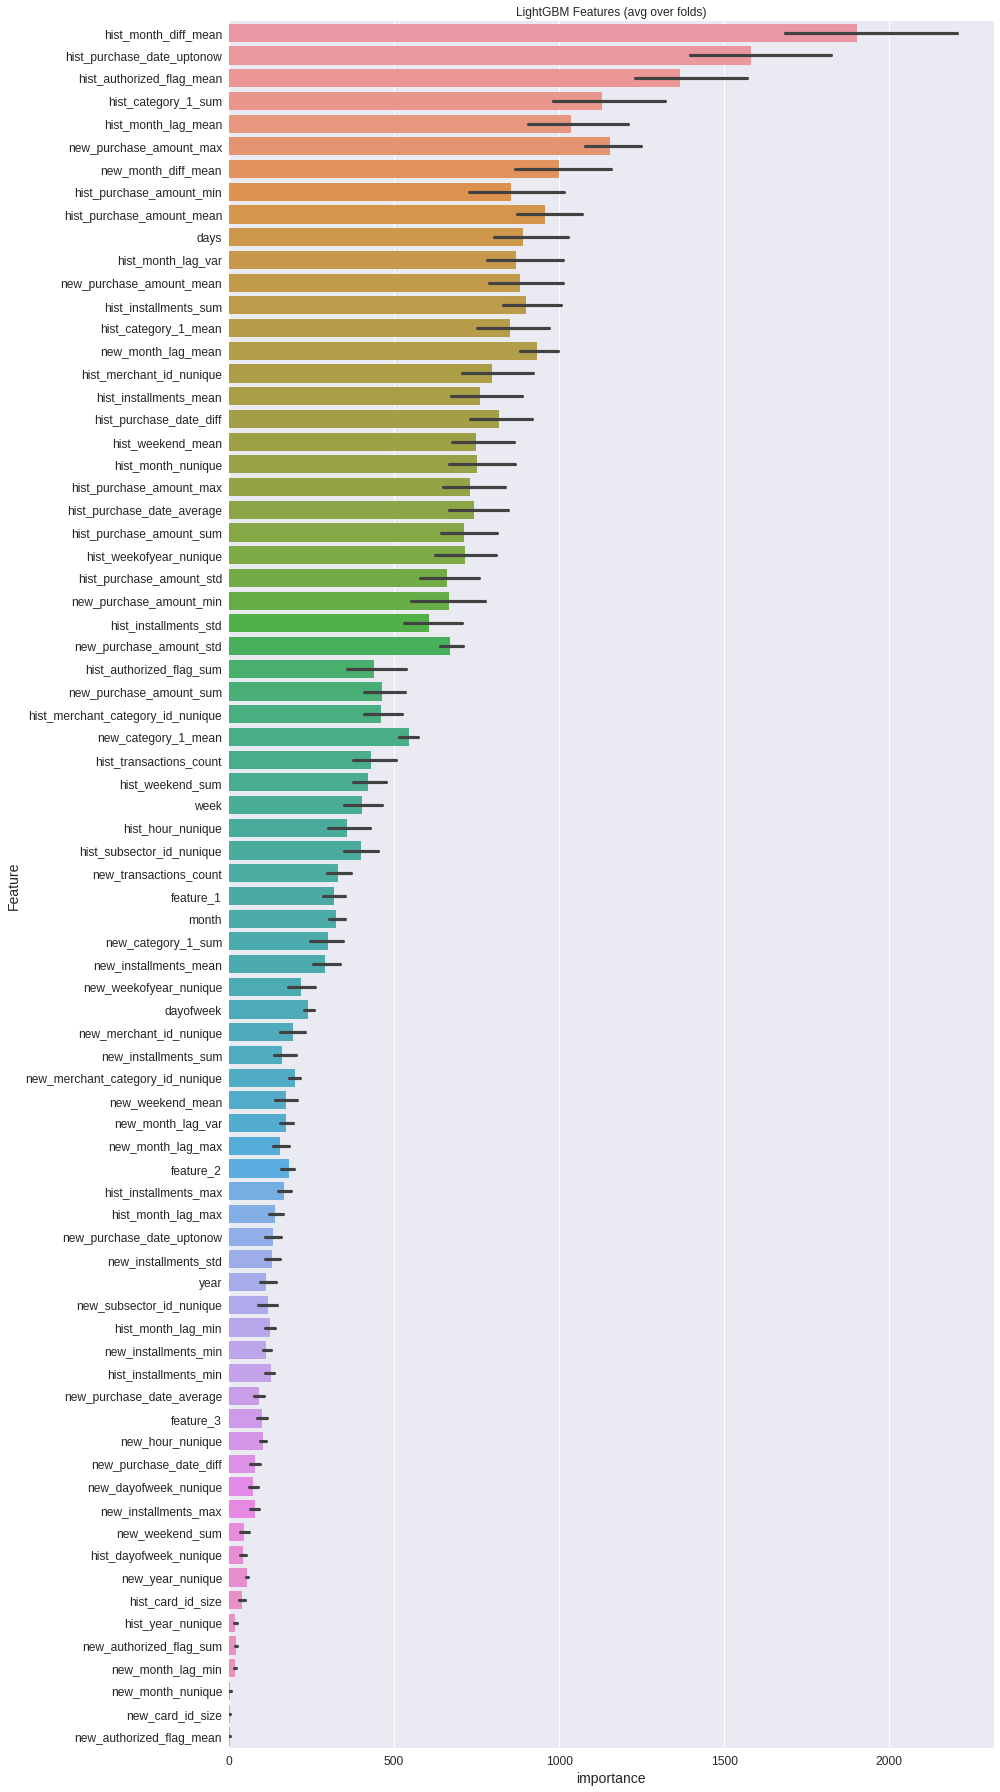

In [35]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

Final Predictions and Submission File.

In [36]:
sample_submission = pd.read_csv('../input/sample_submission.csv')
sample_submission['target'] = predictions
sample_submission.to_csv('submission_ashish_lgbm.csv', index=False)